<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Base" data-toc-modified-id="Base-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Base</a></span><ul class="toc-item"><li><span><a href="#Base-dataset" data-toc-modified-id="Base-dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Base dataset</a></span></li><li><span><a href="#Create-index" data-toc-modified-id="Create-index-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Create index</a></span></li></ul></li></ul></div>

In [1]:
#conda install -c pytorch faiss-cpu=1.7.4 mkl=2021 blas=1.0=mkl
#!conda install -c conda-forge faiss-cpu
#!conda update -n base -c defaults conda
#!pip install faiss-cpu

In [2]:
import pandas as pd
import numpy as np
import faiss
from tqdm.notebook import tqdm
from sklearn.preprocessing import RobustScaler
from catboost import CatBoostRanker, CatBoostClassifier
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
from feature_engine.selection import DropCorrelatedFeatures, DropConstantFeatures, DropDuplicateFeatures, DropHighPSIFeatures

# Load data

## Base

### Base dataset

In [3]:
df_base = pd.read_csv("./base.csv", index_col=0)
df_base.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


In [4]:
df_base.shape

(2918139, 72)

In [5]:
df_base.describe()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,...,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06
mean,-8.622947e+01,8.080077e+00,-4.458080e+01,-1.466350e+02,1.113166e+02,-7.199138e+01,-3.922239e+02,2.035283e+01,1.236842e+02,1.244581e+02,...,-7.902286e+01,3.329735e+01,-1.547962e+02,1.415132e+01,6.779167e+01,2.354490e+01,7.495930e+01,1.155667e+02,-7.993390e+02,-4.779125e+01
std,2.489132e+01,4.953387e+00,3.863166e+01,1.984480e+01,4.634809e+01,2.818607e+01,2.716550e+02,6.421638e+01,6.356109e+00,6.443058e+01,...,3.045642e+01,2.888603e+01,4.122929e+01,9.895115e+01,1.823356e+00,5.534224e+01,6.134500e+01,2.117518e+01,3.854131e+02,4.174802e+01
min,-1.994687e+02,-1.391461e+01,-2.400734e+02,-2.326671e+02,-1.055830e+02,-2.110086e+02,-7.914699e+02,-3.018597e+02,9.315305e+01,-1.738719e+02,...,-2.205662e+02,-8.850774e+01,-3.539028e+02,-1.575944e+02,5.950944e+01,-2.331382e+02,-2.036016e+02,1.572448e+01,-1.297931e+03,-2.267801e+02
25%,-1.030654e+02,4.708491e+00,-6.955949e+01,-1.599051e+02,8.050795e+01,-9.137994e+01,-6.293318e+02,-2.222147e+01,1.194840e+02,8.176751e+01,...,-9.876390e+01,1.698862e+01,-1.807799e+02,-7.130038e+01,6.658096e+01,-1.251624e+01,3.377574e+01,1.016867e+02,-1.074465e+03,-7.566641e+01
50%,-8.623150e+01,8.038950e+00,-4.381661e+01,-1.467768e+02,1.118730e+02,-7.192230e+01,-4.222016e+02,2.080477e+01,1.238923e+02,1.234977e+02,...,-7.848812e+01,3.471502e+01,-1.539773e+02,1.382693e+01,6.781458e+01,2.341649e+01,7.492997e+01,1.160244e+02,-1.074465e+03,-4.859196e+01
75%,-6.925658e+01,1.147007e+01,-1.962527e+01,-1.333277e+02,1.423743e+02,-5.244111e+01,-1.566686e+02,6.391821e+01,1.279705e+02,1.672206e+02,...,-5.853355e+01,5.216429e+01,-1.273405e+02,9.966753e+01,6.902666e+01,5.975511e+01,1.158760e+02,1.295524e+02,-5.057445e+02,-1.971424e+01
max,2.151555e+01,2.993721e+01,1.609372e+02,-5.137478e+01,3.196645e+02,5.880624e+01,1.096325e+02,3.412282e+02,1.522612e+02,4.275421e+02,...,6.017411e+01,1.541678e+02,2.436099e+01,1.850981e+02,7.571203e+01,3.148988e+02,3.395738e+02,2.147063e+02,9.877081e+01,1.269732e+02


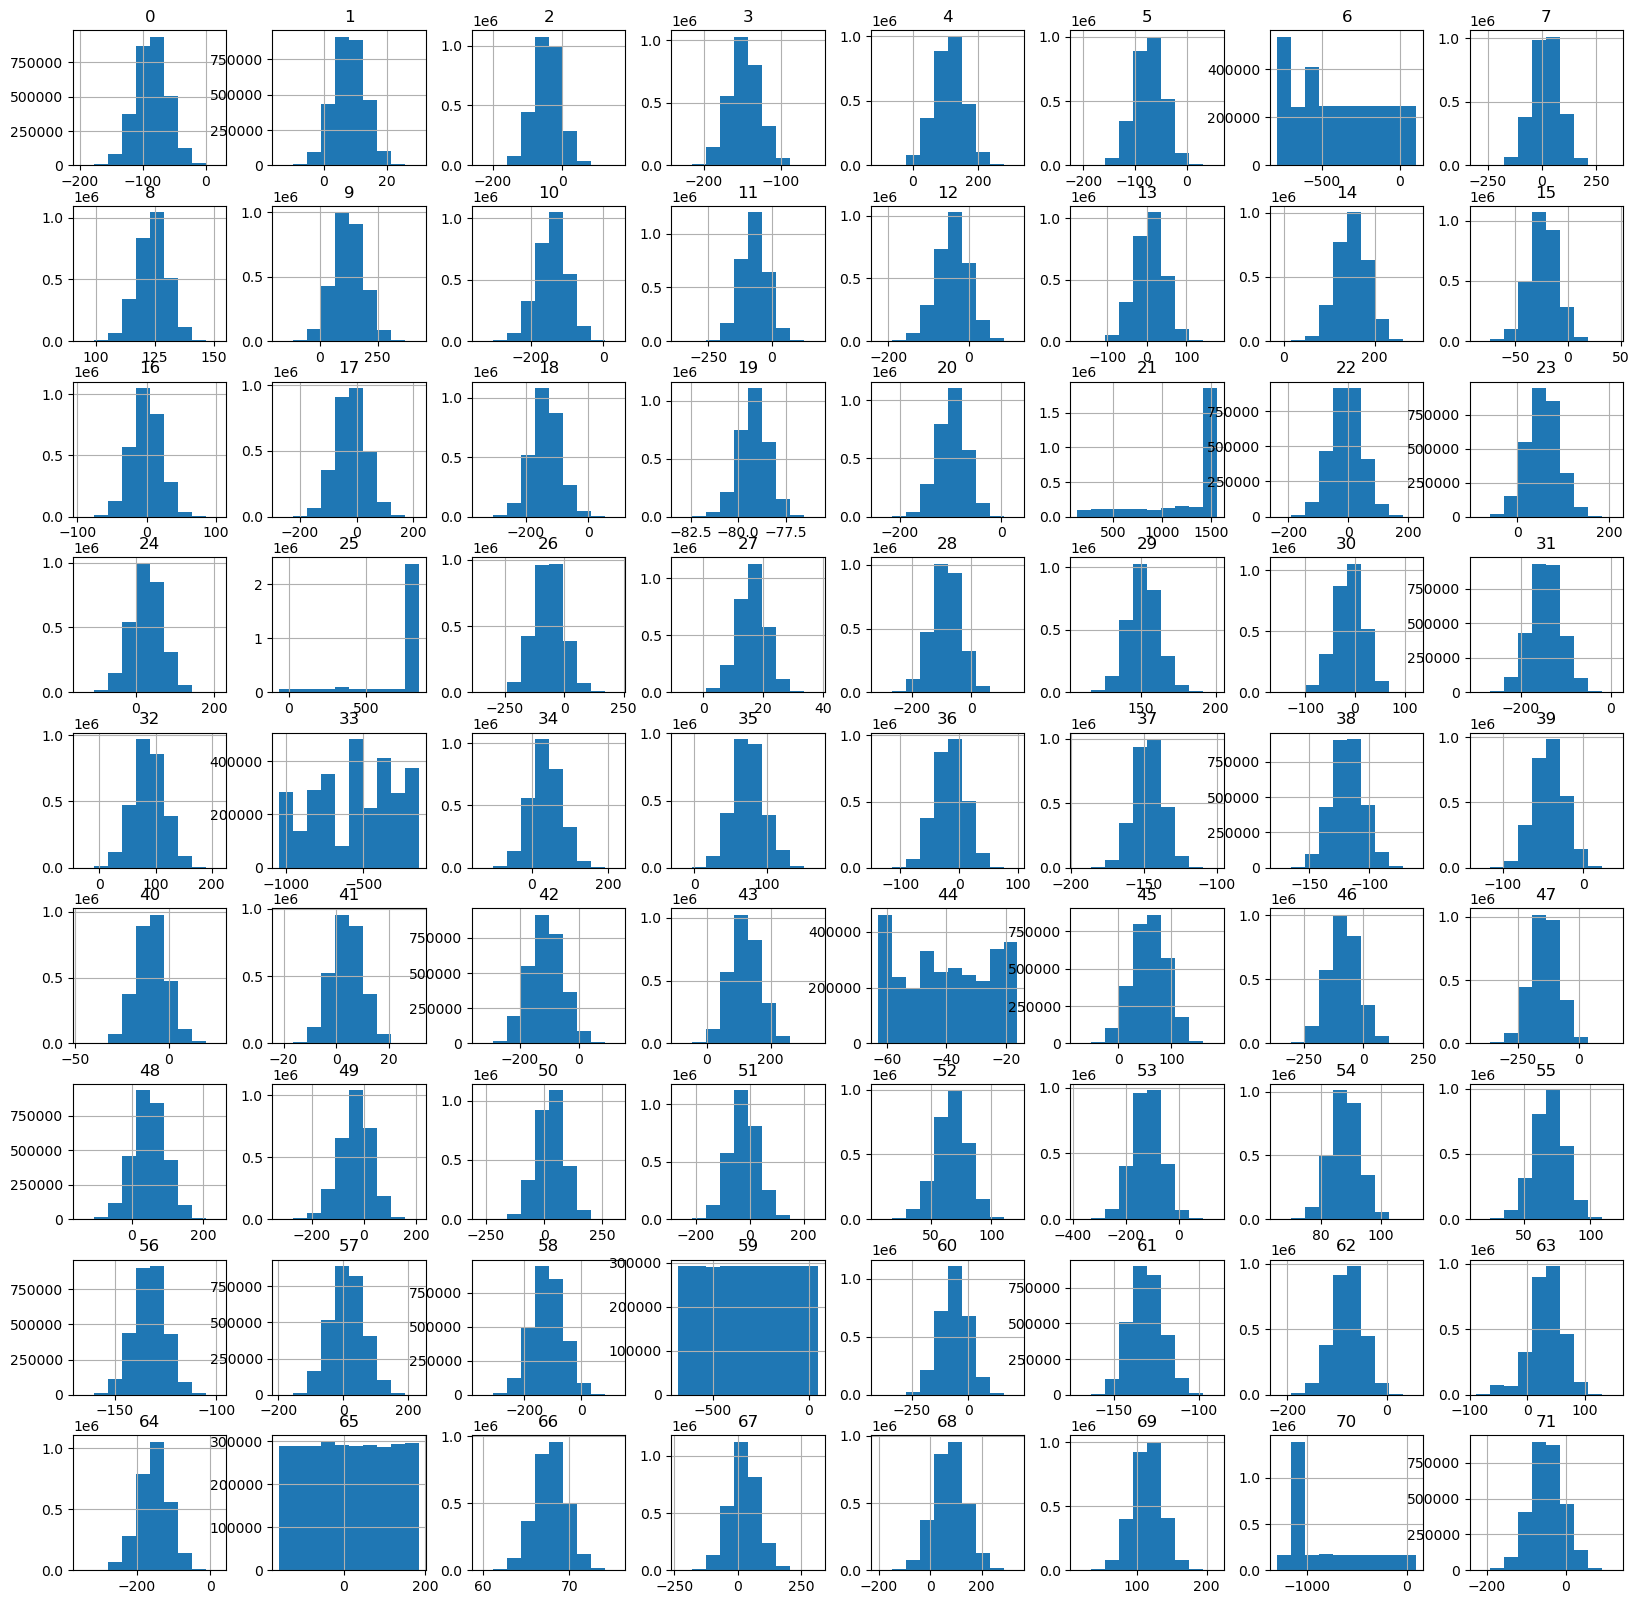

In [6]:
df_base.hist(figsize=(20, 20));

In [7]:
dcf = DropConstantFeatures(tol = 0.5)
df_base_sc = dcf.fit_transform(df_base)
dcf.features_to_drop_

['21', '25']

In [8]:
rs = RobustScaler()
df_base_sc = rs.fit_transform(df_base_sc)

### Create index

In [9]:
dims = df_base_sc.shape[1]
n_cells = 60
# how many cells
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [10]:
idx_l2.train(np.ascontiguousarray(df_base_sc.astype('float32')))
             
idx_l2.add(np.ascontiguousarray(df_base_sc.astype('float32')))

In [11]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

#del df_base

# Train

In [12]:
df_train = pd.read_csv("./train.csv", index_col=0)
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


In [13]:
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)
df_train = dcf.transform(df_train)
df_train = rs.transform(df_train)

In [14]:
%%time
idx_l2.nprobe = 1
r, idx = idx_l2.search(np.ascontiguousarray(df_train).astype('float32'), 50)

Wall time: 47 s


In [15]:
def to_numeric(t):
    t = int(t[:-5])
    return t

In [16]:
targets_num = targets.apply(to_numeric)
targets_num.head(30)

Id
0-query      675816
1-query      366656
2-query     1447819
3-query     1472602
4-query      717819
5-query     2381316
6-query      773187
7-query     2488580
8-query       24129
9-query      775706
10-query    1790410
11-query     607801
12-query     338682
13-query     534514
14-query      88328
15-query     190569
16-query     785982
17-query    1841709
18-query     629793
19-query      75284
20-query     298085
21-query       9331
22-query      25419
23-query     372350
24-query     915740
25-query     167613
26-query    3183220
27-query     562393
28-query     164688
29-query     224353
Name: Target, dtype: int64

In [17]:
def targets_train(t):
    for i in range(idx.shape[0]):
        if t in idx[i]:
            return 1
        else:
            return 0     

In [18]:
targets_train = targets_num.apply(targets_train)

In [19]:
targets_train.value_counts()

0    99996
1        4
Name: Target, dtype: int64

In [20]:
model = CatBoostClassifier(random_state=2023, task_type='GPU', logging_level='Silent')
model.fit(df_train, targets_train)
preds = model.predict(df_base_sc)

In [21]:
pd.Series(preds).value_counts()

0    2918138
1          1
dtype: int64

In [22]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

66.073
